# Predicted fitness of sequences in multiple sequence alignment used for model generation

Note that EVH is only computed for homologs that are gap free.

In [1]:
#########################
#                       #
#                       #
#    LIBRARY IMPORT     #
#                       #
#                       #
#########################

import os, sys
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import AlignIO
from evcouplings.couplings.model import _hamiltonians

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/alignment_devh'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

In [4]:
model = FHS.get_model()
sequences = FHS.get_sequences_df().to_dict('records')
sequences_index = {rec['manuscript_name']: i for i, rec in enumerate(sequences)}
sequences_mapped = np.array([[model.alphabet_map[a] for a in rec['aligned_sequence']] for rec in sequences])
sequences_evh = _hamiltonians(sequences_mapped, model.J_ij, model.h_i)[:, 0]


In [5]:
list(sequences[0].keys())

['manuscript_name',
 'is_design',
 'EVH',
 'functional',
 'full_sequence',
 'aligned_sequence',
 'closest_natural_sequence',
 'natural_align_length',
 'identities_to_natural',
 'mut_to_natural',
 'percent_id_to_natural',
 'model_mutations']

In [6]:
alphabet_map = np.full(256, -1, dtype=int)
for aa, symbol in model.alphabet_map.items():
    alphabet_map[ord(aa)] = symbol

In [7]:
msa_mapped = np.array(AlignIO.read(FHS.msa_filename, 'fasta'), dtype='S1').view(np.int8)
msa_mapped = alphabet_map[msa_mapped]
msa_mapped = msa_mapped[:, msa_mapped[0] >= 0]
msa_mapped = msa_mapped[(msa_mapped >= 0).all(axis=1), :]
msa_evh = _hamiltonians(msa_mapped, model.J_ij, model.h_i)[:, 0]

In [8]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

def rounddown(x):
    return int(math.floor(x / 10.0)) * 10


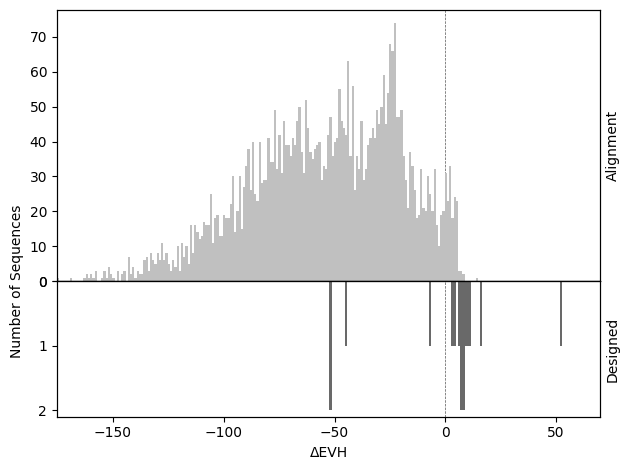

In [9]:
wt_evh = sequences_evh[sequences_index['WT TEM-1']]
msa_devh = msa_evh - wt_evh
sequences_devh = sequences_evh - wt_evh

msa_devh_hist_bin_range = (rounddown(msa_evh.min()) - wt_evh, roundup(msa_evh.max()) - wt_evh)
msa_devh_hist, msa_devh_hist_bin_edges = np.histogram(msa_devh, bins=int(msa_devh_hist_bin_range[1] - msa_devh_hist_bin_range[0]), range=msa_devh_hist_bin_range)

seqs_devh_hist_bin_range = (rounddown(sequences_evh.min()) - wt_evh, roundup(sequences_evh.max()) - wt_evh)
seqs_devh_hist, seqs_devh_hist_bins = np.histogram(sequences_devh[1:], bins=int(seqs_devh_hist_bin_range[1] - seqs_devh_hist_bin_range[0]), range=seqs_devh_hist_bin_range)

cdf = msa_devh_hist.cumsum()
cdf = cdf / cdf[-1]
threshold = 1e-8
xmin = msa_devh_hist_bin_edges[np.argmax(cdf >= threshold)]
xmax = roundup(max(msa_devh_hist_bin_edges[-1], seqs_devh_hist_bins[-1]))

y_tick_locator = mpl.ticker.MaxNLocator(integer=True, nbins='auto', steps=[1, 2, 5, 10])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [2, 0, 1], 'hspace': 0})
ax1.axvline(x=0, color='#555555', linewidth=0.5, linestyle='--', zorder=0)
ax1.hist(msa_devh_hist_bin_edges[:-1], msa_devh_hist_bin_edges, weights=msa_devh_hist, color='silver', zorder=1)
ax1.set_xlabel('ΔEVH')
ax1.set_xlim(xmin, xmax)
ax1t = ax1.twinx()
ax1t.set_ylabel('Alignment')
ax1t.tick_params(right=False, labelright=False)

ax2.set_ylabel('Number of Sequences')
ax2.tick_params(axis='y', left=False, labelleft=False)

ax3.invert_yaxis()
ax3.axvline(x=0, color='#555555', linewidth=0.5, linestyle='--', zorder=0)
ax3.hist(seqs_devh_hist_bins[:-1], seqs_devh_hist_bins, weights=seqs_devh_hist, color='dimgrey', zorder=1)
ax3.set_xlabel('ΔEVH')
ax3.set_xlim(xmin, xmax)
ax3.yaxis.set_major_locator(y_tick_locator)
ax3t = ax3.twinx()
ax3t.set_ylabel('Designed')
ax3t.tick_params(right=False, labelright=False)

fig.align_labels()
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'alignment_devh.pdf'), bbox_inches='tight')
